**Name: Tavish Shetty**

**Roll No: C101**

Problem 1 - Modelling Frong on a Rock

In [21]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
states = ["rock_0", "rock_1", "land", "water"]
n_states = len(states)

# Define actions: jump to next rock/land
actions = ["jump_to_rock1", "jump_to_land"]
n_actions = len(actions)

# Success probability
success_prob = 0.9
fail_prob = 0.1

In [8]:
def define_transitions():
    # Transition probability matrix P[a][s, s']
    P = np.zeros((n_actions, n_states, n_states))
    
    # From rock_0, can only jump to rock_1
    P[0, 0, 1] = success_prob  # rock_0 -> rock_1 (success)
    P[0, 0, 3] = fail_prob     # rock_0 -> water (fail)
    
    # From rock_1, can only jump to land
    P[1, 1, 2] = success_prob  # rock_1 -> land (success)
    P[1, 1, 3] = fail_prob     # rock_1 -> water (fail)
    
    # When in water, return to the rock you jumped from
    P[0, 3, 0] = 1.0  # water -> rock_0 (after failing jump from rock_0)
    P[1, 3, 1] = 1.0  # water -> rock_1 (after failing jump from rock_1)
    
    # Land is terminal state
    P[0, 2, 2] = 1.0
    P[1, 2, 2] = 1.0
    
    return P

In [9]:
def define_rewards():
    # Reward matrix R[s, a]
    R = np.zeros((n_states, n_actions))
    
    # Reward for reaching land
    R[2, :] = 1  # Reward for being in land state
    
    # Penalty for falling in water
    R[3, :] = -1  # Penalty for being in water state
    
    return R

In [10]:

def value_iteration(P, R, gamma=0.9, theta=1e-6, max_iter=1000):
    V = np.zeros(n_states)
    policy = np.zeros(n_states, dtype=int)
    
    for i in range(max_iter):
        delta = 0
        for s in range(n_states):
            if s == 2:  # Terminal state (land)
                continue
                
            v = V[s]
            q_values = np.zeros(n_actions)
            
            for a in range(n_actions):
                for s_next in range(n_states):
                    q_values[a] += P[a, s, s_next] * (R[s, a] + gamma * V[s_next])
            
            V[s] = max(q_values)
            policy[s] = np.argmax(q_values)
            delta = max(delta, abs(v - V[s]))
        
        if delta < theta:
            break
    
    return policy, V

In [11]:
P = define_transitions()
R = define_rewards()
policy, V = value_iteration(P, R)

print("State Values:")
for i, state in enumerate(states):
    print(f"{state}: {V[i]:.4f}")

print("\nOptimal Policy:")
for i, state in enumerate(states):
    if i == 2:  # land is terminal
        print(f"{state}: Terminal state")
    else:
        print(f"{state}: {actions[policy[i]]}")

# Define the uniform random policy
print("\nUniform Random Policy:")
for state in states:
    if state == "land":
        print(f"{state}: Terminal state")
    else:
        print(f"{state}: Choose an action randomly with equal probability")

State Values:
rock_0: 0.0000
rock_1: 0.0000
land: 0.0000
water: -1.0000

Optimal Policy:
rock_0: jump_to_land
rock_1: jump_to_rock1
land: Terminal state
water: jump_to_rock1

Uniform Random Policy:
rock_0: Choose an action randomly with equal probability
rock_1: Choose an action randomly with equal probability
land: Terminal state
water: Choose an action randomly with equal probability


Problem 2- Modelling Frong on a Rock 2

In [12]:
N_DIRECTIONS = 4  # South, West, North, East
DIRECTIONS = ["South", "West", "North", "East"]
MAX_JUMPS = 100
EPSILON = 0.1  # For epsilon-greedy
C = 2.0  # For UCB

In [13]:
def initialize_environment(mean_rewards=None):
    """Initialize the frog's environment with rewards in each direction"""
    if mean_rewards is None:
        # Random rewards if none provided
        mean_rewards = np.random.uniform(1, 10, N_DIRECTIONS)
    
    return {
        "mean_rewards": mean_rewards,
        "std_dev": 0.2  # Standard deviation of reward distribution
    }

In [14]:
def jump_and_catch_flies(direction, env):
    """Frog jumps in given direction and catches flies"""
    # Generate reward (number of flies caught)
    reward = np.random.normal(env["mean_rewards"][direction], env["std_dev"])
    reward = max(0, reward)  # Can't catch negative flies
    return reward

In [15]:
def epsilon_greedy_strategy(q_values, action_counts, epsilon=EPSILON):
    """Epsilon-greedy action selection strategy"""
    if np.random.random() < epsilon:
        # Explore: random action
        return np.random.randint(0, N_DIRECTIONS)
    else:
        # Exploit: best action
        return np.argmax(q_values)

In [16]:
def update_q_values(q_values, action_counts, action, reward):
    """Update Q-values based on received reward"""
    action_counts[action] += 1
    q_values[action] += (reward - q_values[action]) / action_counts[action]
    return q_values, action_counts

In [17]:
def ucb_strategy(q_values, action_counts, total_count, c=C):
    """Upper Confidence Bound action selection strategy"""
    # Initial exploration of all actions
    if np.any(action_counts == 0):
        return np.argmin(action_counts)
    
    # Calculate UCB values
    ucb_values = q_values + c * np.sqrt(np.log(total_count) / action_counts)
    return np.argmax(ucb_values)

In [18]:
def run_epsilon_greedy(env, max_jumps=MAX_JUMPS):
    """Run the epsilon-greedy strategy"""
    q_values = np.zeros(N_DIRECTIONS)
    action_counts = np.zeros(N_DIRECTIONS)
    rewards = []
    
    for _ in range(max_jumps):
        # Select direction
        direction = epsilon_greedy_strategy(q_values, action_counts)
        
        # Jump and get reward
        reward = jump_and_catch_flies(direction, env)
        rewards.append(reward)
        
        # Update Q-values
        q_values, action_counts = update_q_values(q_values, action_counts, direction, reward)
    
    return rewards, q_values, action_counts

In [19]:
def run_ucb(env, max_jumps=MAX_JUMPS):
    """Run the UCB strategy"""
    q_values = np.zeros(N_DIRECTIONS)
    action_counts = np.zeros(N_DIRECTIONS)
    total_count = 0
    rewards = []
    
    for _ in range(max_jumps):
        # Select direction
        direction = ucb_strategy(q_values, action_counts, total_count)
        
        # Jump and get reward
        reward = jump_and_catch_flies(direction, env)
        rewards.append(reward)
        
        # Update counts and Q-values
        action_counts[direction] += 1
        total_count += 1
        q_values[direction] += (reward - q_values[direction]) / action_counts[direction]
    
    return rewards, q_values, action_counts

In [20]:
def run_experiments(env, n_experiments=100):
    """Run multiple experiments and average the results"""
    all_eps_rewards = []
    all_ucb_rewards = []
    
    for _ in range(n_experiments):
        eps_rewards, _, _ = run_epsilon_greedy(env)
        ucb_rewards, _, _ = run_ucb(env)
        
        all_eps_rewards.append(eps_rewards)
        all_ucb_rewards.append(ucb_rewards)
    
    # Average the results
    avg_eps_rewards = np.mean(all_eps_rewards, axis=0)
    avg_ucb_rewards = np.mean(all_ucb_rewards, axis=0)
    
    return avg_eps_rewards, avg_ucb_rewards

In [22]:
def plot_results(eps_rewards, ucb_rewards, env):
    """Plot the results"""
    plt.figure(figsize=(10, 8))
    
    # Plot average rewards
    plt.subplot(2, 1, 1)
    plt.plot(eps_rewards, label='Epsilon-Greedy')
    plt.plot(ucb_rewards, label='UCB')
    plt.xlabel('Jump Number')
    plt.ylabel('Average Reward (flies caught)')
    plt.title('Average Reward per Jump')
    plt.legend()
    
    # Plot cumulative rewards
    plt.subplot(2, 1, 2)
    plt.plot(np.cumsum(eps_rewards), label='Epsilon-Greedy')
    plt.plot(np.cumsum(ucb_rewards), label='UCB')
    plt.xlabel('Jump Number')
    plt.ylabel('Cumulative Reward')
    plt.title('Cumulative Reward over Time')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

Running experiments...
Epsilon-Greedy total reward: 575.10
UCB total reward: 682.82
Direction with highest mean reward: West (7.00)


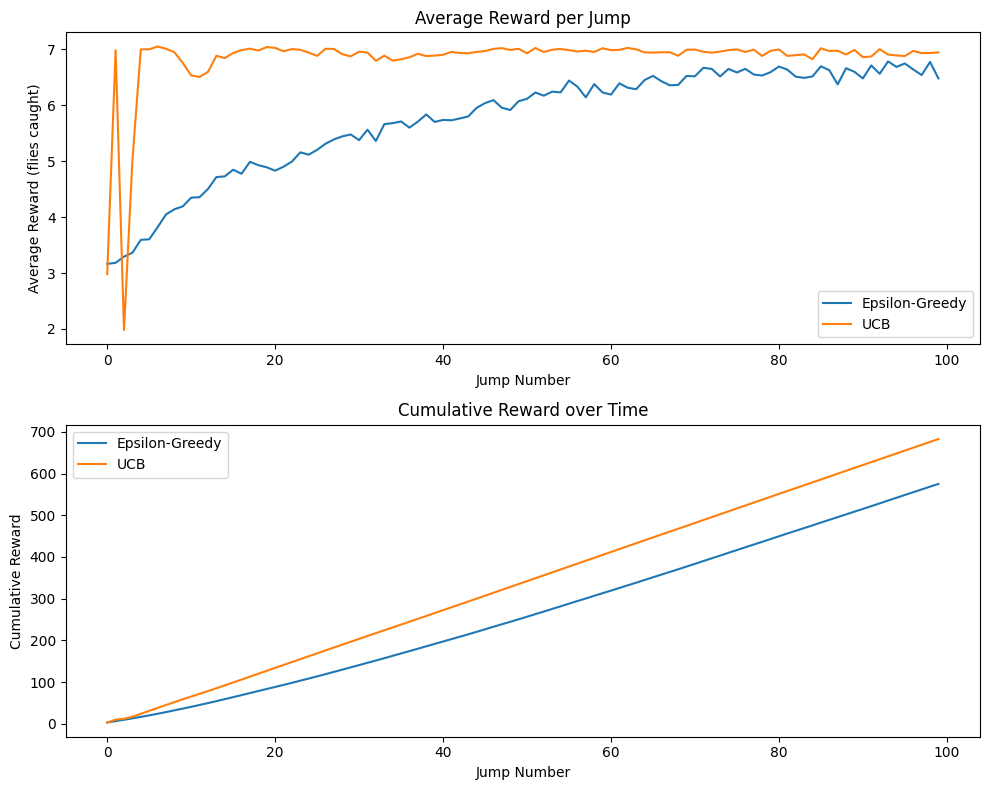


Exploration Strategy Analysis (Part b):
1. Epsilon-Greedy:
   - Advantage: Simple implementation, consistent exploration
   - Disadvantage: Exploration is random, doesn't use past knowledge
2. UCB:
   - Advantage: Intelligent exploration based on uncertainty
   - Disadvantage: More complex, requires tuning exploration parameter

Limited Jumps Analysis (Part c):
With φ=100 jumps:
   - MAB is still appropriate but with a finite horizon
   - Early exploration becomes more important
   - Time-dependent strategies might be more optimal

Passive Observer Analysis (Part d):
If we can't control Hop Along:
   - Would need a passive learning approach
   - Could use inverse reinforcement learning to understand the frog's policy
   - Similar to observing oil extraction results without controlling sites


In [23]:
# Create environment with fixed rewards for reproducibility
mean_rewards = [3, 7, 2, 5]  # Mean rewards for South, West, North, East
env = initialize_environment(mean_rewards)

print("Running experiments...")
eps_rewards, ucb_rewards = run_experiments(env)

# Compare final cumulative rewards
print(f"Epsilon-Greedy total reward: {np.sum(eps_rewards):.2f}")
print(f"UCB total reward: {np.sum(ucb_rewards):.2f}")

# Show which direction had highest mean reward
best_direction = DIRECTIONS[np.argmax(env["mean_rewards"])]
print(f"Direction with highest mean reward: {best_direction} ({np.max(env['mean_rewards']):.2f})")

# Plot results
plot_results(eps_rewards, ucb_rewards, env)

# Analysis for parts b, c, and d
print("\nExploration Strategy Analysis (Part b):")
print("1. Epsilon-Greedy:")
print("   - Advantage: Simple implementation, consistent exploration")
print("   - Disadvantage: Exploration is random, doesn't use past knowledge")

print("2. UCB:")
print("   - Advantage: Intelligent exploration based on uncertainty")
print("   - Disadvantage: More complex, requires tuning exploration parameter")

print("\nLimited Jumps Analysis (Part c):")
print(f"With φ={MAX_JUMPS} jumps:")
print("   - MAB is still appropriate but with a finite horizon")
print("   - Early exploration becomes more important")
print("   - Time-dependent strategies might be more optimal")

print("\nPassive Observer Analysis (Part d):")
print("If we can't control Hop Along:")
print("   - Would need a passive learning approach")
print("   - Could use inverse reinforcement learning to understand the frog's policy")
print("   - Similar to observing oil extraction results without controlling sites")